In [74]:
import pandas as pd
import numpy as np

In [75]:
# Load the dataset
df = pd.read_csv("ola_sample_data.csv", parse_dates=['ts'])


In [76]:
df.head()

,number,ts,pick_lat,pick_lng,drop_lat,drop_lng
0,1,2025-07-05 16:05:32,14.172208,75.839013,14.166019,76.319742
1,2,2025-07-17 11:53:11,18.137538,76.200802,13.885717,77.439911
2,3,2025-07-02 15:23:32,16.632267,77.928646,12.806880,76.605349
3,4,2025-06-27 02:01:42,15.714629,75.595866,15.773872,74.432059
4,5,2025-07-12 18:06:14,12.668306,77.997115,14.874768,74.895754


In [78]:
# General information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   number    5000 non-null   int64         
 1   ts        5000 non-null   datetime64[ns]
 2   pick_lat  5000 non-null   float64       
 3   pick_lng  5000 non-null   float64       
 4   drop_lat  5000 non-null   float64       
 5   drop_lng  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 234.5 KB


# DATA CLEANING, ANALYSIS AND VISUALIZATION

In [79]:
# Check each column for missing (NaN) values.
missing_values = df.isnull().sum()
# Display the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
number      0
ts          0
pick_lat    0
pick_lng    0
drop_lat    0
drop_lng    0
dtype: int64


In [80]:
# Check for duplicate rows
df.duplicated().any()

np.False_

In [84]:
# Sort by user and timestamp
df = df.sort_values(by=['number', 'ts'])

# Remove duplicate requests from the same user within 8 minutes
df['user_time_diff'] = df.groupby('number')['ts'].diff().dt.total_seconds()
df = df[(df['user_time_diff'].isna()) | (df['user_time_diff'] >= 480)]
df.drop(columns='user_time_diff', inplace=True)

# Remove multiple requests from the same area (same lat/lon) within 1 hour
df = df.sort_values(by=['pick_lat', 'pick_lng', 'ts'])
df['loc_time_diff'] = (
    df.groupby(['pick_lat', 'pick_lng'])['ts']
    .diff().dt.total_seconds()
)
df = df[(df['loc_time_diff'].isna()) | (df['loc_time_diff'] >= 3600)]
df.drop(columns='loc_time_diff', inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

In [85]:
# Define Haversine function to calculate distance in meters
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Radius of Earth in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in meters

# Apply the Haversine function row-wise
df['distance_m'] = haversine(
    df['pick_lat'],
    df['pick_lng'],
    df['drop_lat'],
    df['drop_lng']
)

# Filter out rides under 50 meters
df = df[df['distance_m'] >= 50].reset_index(drop=True)

In [103]:
# Drop rows with missing pickup/drop coordinates
df = df.dropna(subset=[
    'pick_lat', 'pick_lng',
    'drop_lat', 'drop_lng'
])

# Convert coordinates to numeric to avoid issues
df['pick_lat'] = pd.to_numeric(df['pick_lat'], errors='coerce')
df['pick_lng'] = pd.to_numeric(df['pick_lng'], errors='coerce')
df['drop_lat'] = pd.to_numeric(df['drop_lat'], errors='coerce')
df['drop_lng'] = pd.to_numeric(df['drop_lng'], errors='coerce')

# Step 1: Filter out coordinates that fall outside Earth's valid range
df = df[
    (df['pick_lat'].between(-90, 90)) &
    (df['pick_lng'].between(-180, 180)) &
    (df['drop_lat'].between(-90, 90)) &
    (df['drop_lng'].between(-180, 180))
]

# Step 2: Remove requests where *either* pickup or drop is outside India's bounding box
# India bounding box: [lat_min, lat_max, lon_min, lon_max]
india_bounds = {
    'lat_min': 6.2325274,
    'lat_max': 35.6745457,
    'lon_min': 68.1113787,
    'lon_max': 97.395561
}

within_india = (
    df['pick_lat'].between(india_bounds['lat_min'], india_bounds['lat_max']) &
    df['pick_lng'].between(india_bounds['lon_min'], india_bounds['lon_max']) &
    df['drop_lat'].between(india_bounds['lat_min'], india_bounds['lat_max']) &
    df['drop_lng'].between(india_bounds['lon_min'], india_bounds['lon_max'])
)

df = df[within_india]

# Step 3: Remove requests with pickup-drop distance > 500km (outside Karnataka service range)
from geopy.distance import geodesic

def compute_distance_km(row):
    lat1 = row['pick_lat']
    lon1 = row['pick_lng']
    lat2 = row['drop_lat']
    lon2 = row['drop_lng']
    
    # Proper null check
    if any(pd.isnull([lat1, lon1, lat2, lon2])):
        return np.nan

    try:
        return geodesic((lat1, lon1), (lat2, lon2)).km
    except:
        return np.nan


df['ride_distance_km'] = df.apply(compute_distance_km, axis=1)

# Remove rides with distance under 0.05 km (50 meters) and over 500 km
df = df[(df['ride_distance_km'] >= 0.05) & (df['ride_distance_km'] <= 500)]


# Drop helper column
df.drop(columns='ride_distance_km', inplace=True)

# Step 4: Keep only rides that occur *within Karnataka bounds* for focus
# Karnataka bounding box: [lat_min, lat_max, lon_min, lon_max]
kar_bounds = {
    'lat_min': 11.5945587,
    'lat_max': 18.4767308,
    'lng_min': 74.0543908,
    'lng_max': 78.588083
}

within_kar = (
    df['pick_lat'].between(kar_bounds['lat_min'], kar_bounds['lat_max']) &
    df['pick_lng'].between(kar_bounds['lng_min'], kar_bounds['lng_max']) &
    df['drop_lat'].between(kar_bounds['lat_min'], kar_bounds['lat_max']) &
    df['drop_lng'].between(kar_bounds['lng_min'], kar_bounds['lng_max'])
)

df = df[within_kar].reset_index(drop=True)


In [93]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv("ola_ride_requests_cleaned.csv", index=False)

In [97]:
# Extract core datetime features
df['hour'] = df['ts'].dt.hour
df['minute'] = df['ts'].dt.minute
df['day'] = df['ts'].dt.day
df['month'] = df['ts'].dt.month
df['day_of_week'] = df['ts'].dt.dayofweek  # Monday=0, Sunday=6

# Flag weekends
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Define part of day
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['part_of_day'] = df['hour'].apply(get_part_of_day)


In [98]:
# One-hot encode 'day_of_week' and 'part_of_day'
df_encoded = pd.get_dummies(df, columns=['day_of_week', 'part_of_day'], prefix=['dow', 'pod'])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 0 to 4138
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   number       4139 non-null   int64         
 1   ts           4139 non-null   datetime64[ns]
 2   pick_lat     4139 non-null   float64       
 3   pick_lng     4139 non-null   float64       
 4   drop_lat     4139 non-null   float64       
 5   drop_lng     4139 non-null   float64       
 6   distance_m   4139 non-null   float64       
 7   hour         4139 non-null   int32         
 8   minute       4139 non-null   int32         
 9   day          4139 non-null   int32         
 10  month        4139 non-null   int32         
 11  day_of_week  4139 non-null   int32         
 12  is_weekend   4139 non-null   int64         
 13  part_of_day  4139 non-null   object        
dtypes: datetime64[ns](1), float64(5), int32(5), int64(2), object(1)
memory usage: 372.0+ KB


In [100]:
df.describe()

,number,ts,pick_lat,pick_lng,drop_lat,drop_lng,distance_m,hour,minute,day,month,day_of_week,is_weekend
count,4139.000000,4139,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000,4139.000000
mean,2509.995651,2025-07-10 05:44:55.280502528,15.047794,76.284959,15.004769,76.340085,277000.371204,11.510268,29.554965,15.755013,6.799468,2.999517,0.266731
min,1.000000,2025-06-24 19:07:36,11.594639,74.054630,11.601049,74.055535,7039.633979,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000
25%,1255.500000,2025-07-02 08:09:55,13.550673,75.207787,13.480929,75.275383,181452.295679,5.000000,15.000000,8.000000,7.000000,1.000000,0.000000
50%,2508.000000,2025-07-10 05:00:28,15.074851,76.259452,14.961814,76.363862,277443.899029,11.000000,29.000000,16.000000,7.000000,3.000000,0.000000
75%,3761.500000,2025-07-18 04:43:51.500000,16.547102,77.343667,16.522955,77.413638,377121.077177,18.000000,45.000000,24.000000,7.000000,5.000000,1.000000
max,5000.000000,2025-07-25 18:58:03,18.474788,78.585840,18.475390,78.587500,502398.946005,23.000000,59.000000,30.000000,7.000000,6.000000,1.000000
std,1446.697632,NaN,1.856456,1.276719,1.863201,1.272271,121314.390785,6.946775,17.349952,8.740715,0.400446,1.931900,0.442304


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import plotly.express as px

In [105]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

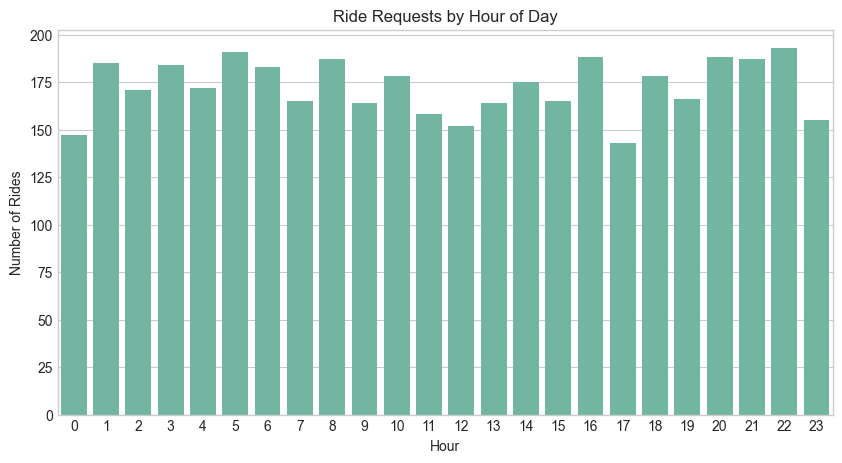

In [106]:
# Distribution of ride requests over hours of the day
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hour')
plt.title('Ride Requests by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.xticks(rotation=0)
plt.show()

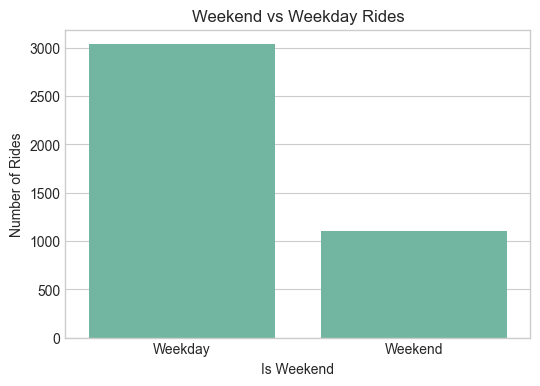

In [108]:
# Ride requests by weekend vs weekday
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='is_weekend')
plt.title('Weekend vs Weekday Rides')
plt.xlabel('Is Weekend')
plt.ylabel('Number of Rides')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

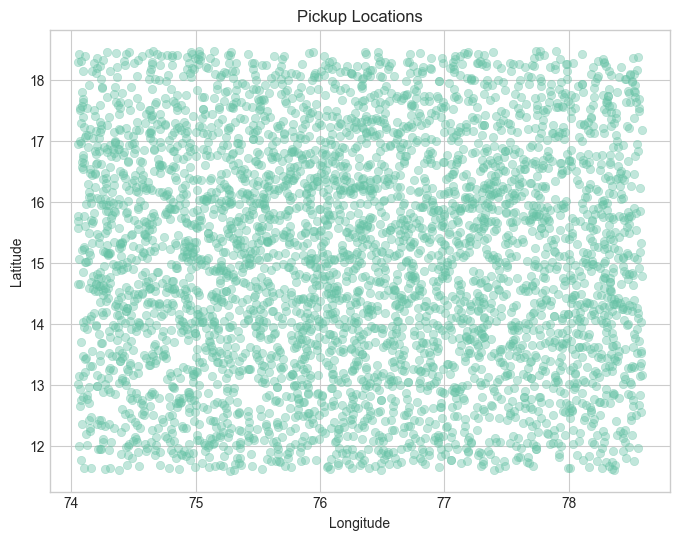

In [109]:
# Scatter plot of pickup locations
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='pick_lng', y='pick_lat', alpha=0.4, edgecolor=None)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

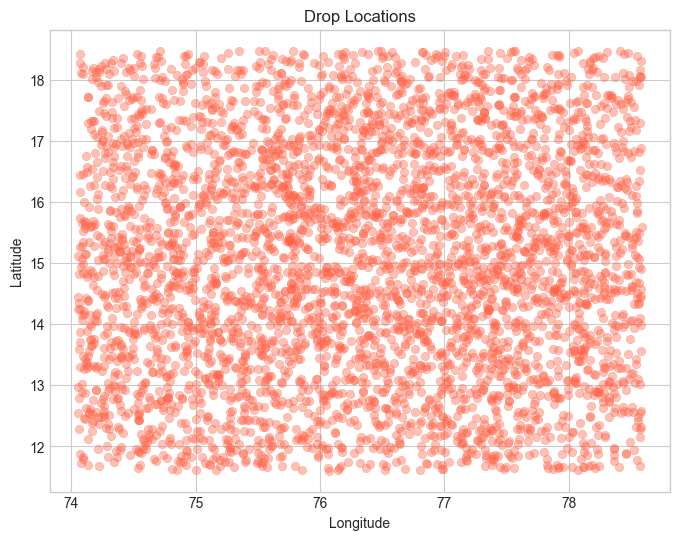

In [110]:
# Scatter plot of drop locations
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='drop_lng', y='drop_lat', alpha=0.4, edgecolor=None, color='tomato')
plt.title('Drop Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

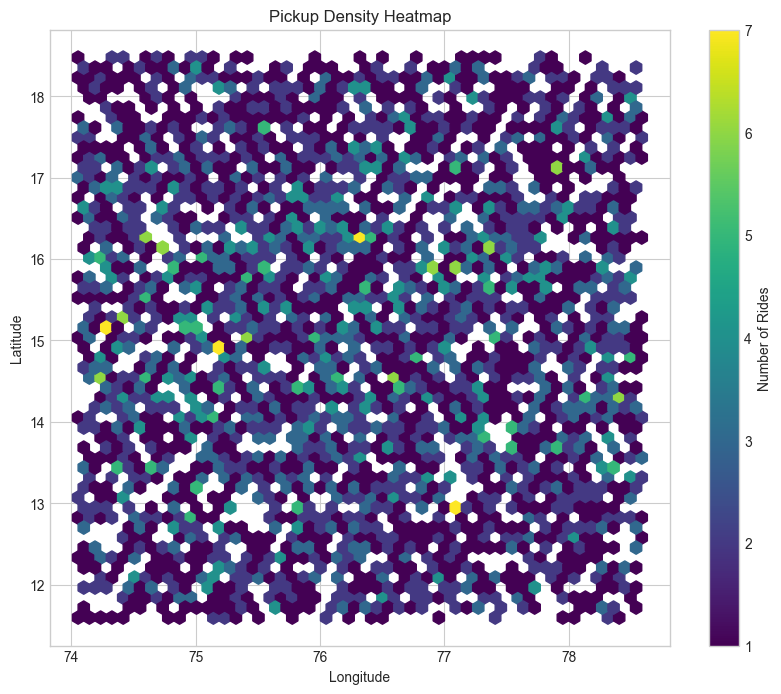

In [111]:
# Heatmap of pickup density (hexbin)
plt.figure(figsize=(10, 8))
plt.hexbin(df['pick_lng'], df['pick_lat'], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Number of Rides')
plt.title('Pickup Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

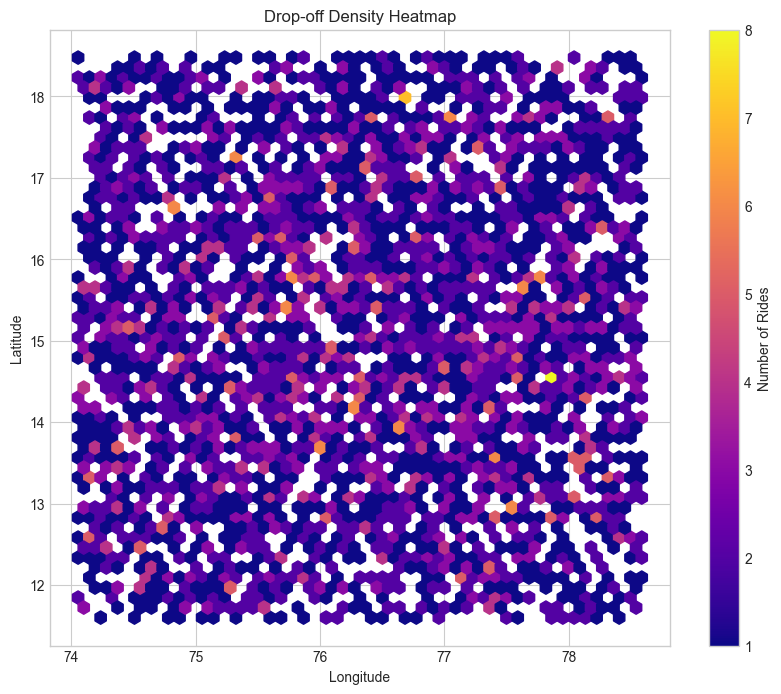

In [112]:
# Heatmap of drop density (hexbin)
plt.figure(figsize=(10, 8))
plt.hexbin(df['drop_lng'], df['drop_lat'], gridsize=50, cmap='plasma', mincnt=1)
plt.colorbar(label='Number of Rides')
plt.title('Drop-off Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

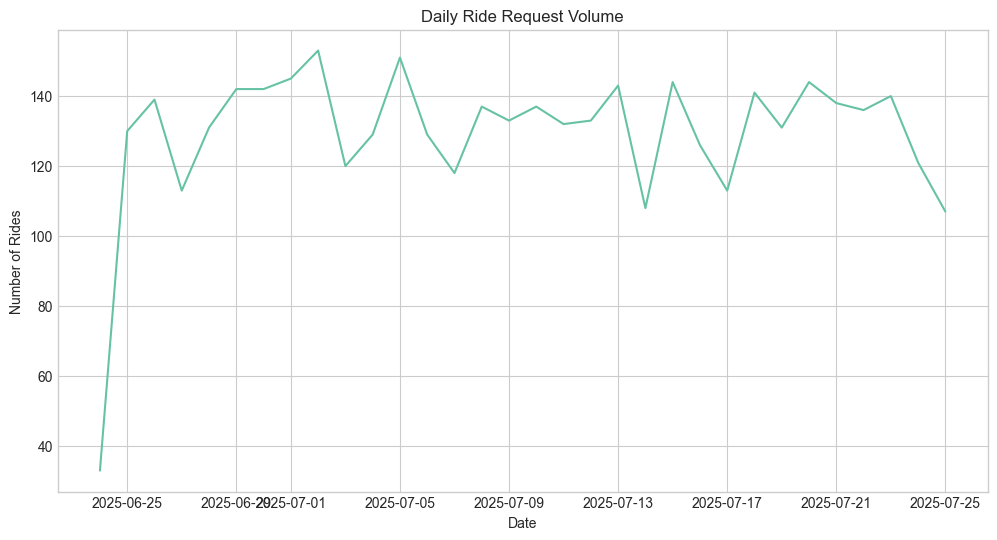

In [113]:
# Time series of daily ride volumes
df['date_only'] = df['ts'].dt.date
daily_counts = df.groupby('date_only').size()

plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Daily Ride Request Volume')
plt.xlabel('Date')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

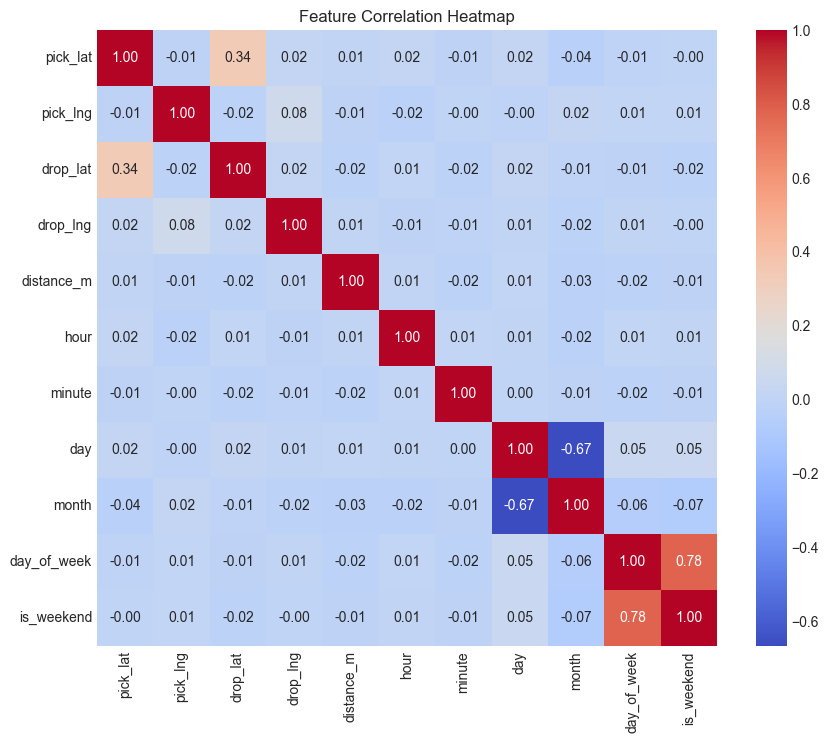

In [114]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_features = df.select_dtypes(include='number').drop(columns='number')  # Drop unique ID
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()